In [1]:
import matplotlib.image as mpimg
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2yiq
from collections import defaultdict 
import cv2
%matplotlib inline

In [47]:
img = io.imread('test.png')
img_s = io.imread('test_s.png')
print(img.dtype, img.shape)
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
g_img_s = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)


uint8 (550, 1000, 4)


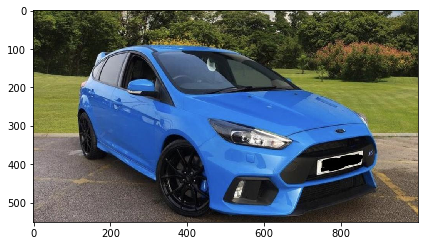

In [48]:
io.imshow(img)

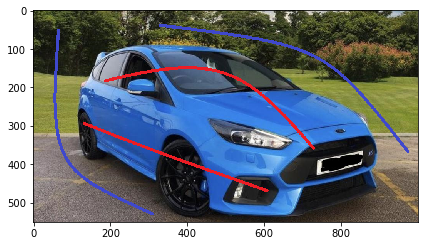

In [49]:
io.imshow(img_s)

In [50]:
scribble = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if g_img[i,j] !=  g_img_s[i,j]:
            scribble.append((i,j))
# print(scribble)

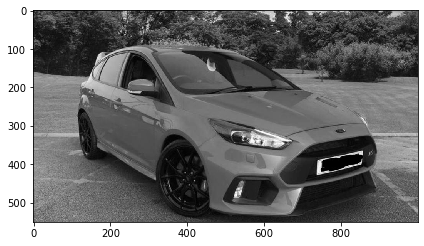

In [51]:
io.imshow(g_img)

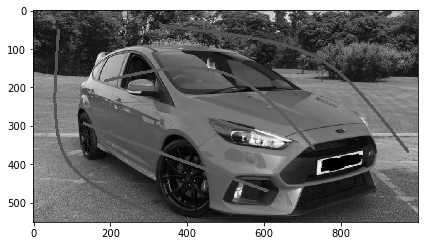

In [52]:
io.imshow(g_img_s)

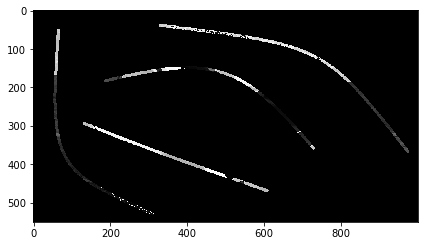

In [53]:
diff = g_img - g_img_s
io.imshow(diff)
io.imsave('diff.png', diff)

In [54]:
scribble_diff = []
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i,j] > 0:
            scribble_diff.append((i,j))
# print(scribble_diff)

In [55]:
scribble == scribble_diff # Need to see why 

True

In [60]:
img_s_key = set()
rgb_s = mpimg.imread('test_s.png')[:,:,:3]
yuv_s = rgb2yiq(rgb_s)
for i, j in scribble:
    img_s_key.add(tuple(rgb_s[i,j,:3]))
img_s_key # should only have two values
# Need to check that the scribbles are purely a single colour and do not shade at the edges

{(0.24705882, 0.28235295, 0.8), (0.92941177, 0.10980392, 0.14117648)}

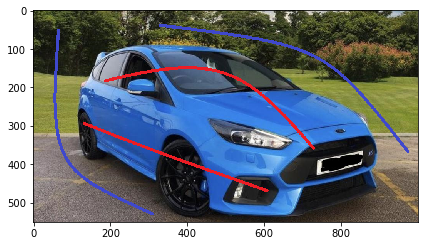

In [12]:
io.imshow(img_s)

In [89]:
def find_marked_locations(rgb, rgb_s):
    g = cv2.cvtColor(io.imread(rgb), cv2.COLOR_RGB2GRAY)
    g_s = cv2.cvtColor(io.imread(rgb_s), cv2.COLOR_RGB2GRAY)
    scribble = []
    non_scribble = []
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if g[i,j] !=  g_s[i,j]:
                scribble.append((i, j))
            else:
                non_scribble.append((i, j))
    return scribble, non_scribble

In [90]:
def compute_pdfs(imfile, imfile_scrib):
    rgb = mpimg.imread(imfile)[:,:,:3]
    yuv = rgb2yiq(rgb)
    rgb_s = mpimg.imread(imfile_scrib)[:,:,:3]
    yuv_s = rgb2yiq(rgb_s)
    # io.imshow(rgb)
    # io.imshow(rgb_s)
        
    # find the scribble pixels    
    # scribbles = find_marked_locations(rgb, rgb_s)
    scribbles, _ = find_marked_locations(imfile, imfile_scrib)
    if not scribbles:
        raise Exception

    imageo = np.zeros(yuv.shape)
    
    # separately store background and foreground scribble pixels in the dictionary comps
    comps = defaultdict(lambda:np.array([]).reshape(0,3))
    for (i, j) in scribbles:
         imageo[i,j,:] = rgb_s[i,j,:]
         # scribble color as key of comps
         comps[tuple(imageo[i,j,:])] = np.vstack([comps[tuple(imageo[i,j,:])], yuv[i,j,:]])
         mu, Sigma = {}, {}
    # compute MLE parameters for Gaussians
    for c in comps:
         mu[c] = np.mean(comps[c], axis=0)
         Sigma[c] = np.cov(comps[c].T)
    return (mu, Sigma)

In [91]:
# Check to see what they mean
m, s = compute_pdfs('test.png', 'test_s.png')

In [92]:
m

{(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([ 0.35788471,  0.04351169, -0.04025798]),
 (0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([ 0.28854334, -0.11953232,  0.03032429])}

In [93]:
s

{(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([[ 0.02901452,  0.00399796, -0.00256678],
        [ 0.00399796,  0.00088867, -0.00091781],
        [-0.00256678, -0.00091781,  0.00163366]]),
 (0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([[ 0.02928617, -0.01127567,  0.00223877],
        [-0.01127567,  0.01268584, -0.0032184 ],
        [ 0.00223877, -0.0032184 ,  0.00098138]])}

In [94]:
import scipy.stats as ss 
pixel_val = [0.2434,  0.244234,  0.3546]
var0 = ss.multivariate_normal.pdf(pixel_val, m[(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929)], s[(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929)])

In [95]:
var1 = ss.multivariate_normal.pdf(pixel_val, m[(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231)], s[(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231)])

In [96]:
var2 = var0 + var1
print(var0/var2, var1/var2) # Source and Sink Weights 

3.569064274648747e-16 0.9999999999999997


In [98]:
def assign_scribble_pixels():
    scribbles_pos, _ = find_marked_locations('test.png', 'test_s.png')
    scribbles_pos_dict = defaultdict(list)
    rgb_s = mpimg.imread('test_s.png')[:,:,:3]
    for pos in scribbles_pos:
        if tuple(rgb_s[pos[0], pos[1]]) in img_s_key:
            scribbles_pos_dict[tuple(rgb_s[pos[0], pos[1]])].append(pos)
    
    # Sanity Check 
    print(len(scribbles_pos_dict))
    l = 0
    for k in scribbles_pos_dict:
        l += len(scribbles_pos_dict[k])
    
    if l == len(scribbles_pos):
        print('OK')
    # ------------
    return scribbles_pos_dict

scribbles_pos_dict = assign_scribble_pixels()

2
OK


## Constructing Graph for QA with Source and Sink nodes

In [87]:
s_J = {}
r, c = g_img.shape[:2]
k1, k2 = list(scribbles_pos_dict.keys())

for pos in scribbles_pos_dict[k1]:
    s_J[(pos[0]*c + pos[1], 's')] = 1
    s_J[(pos[0]*c + pos[1], 't')] = 0

for pos in scribbles_pos_dict[k2]:
    s_J[(pos[0]*c + pos[1], 't')] = 1
    s_J[(pos[0]*c + pos[1], 's')] = 0  


In [99]:
_, non_scribbles_pos = find_marked_locations('test.png', 'test_s.png')
# TBD 

--------------------------------------------------
## Constructing Graph for QA from g_img Intensities

In [18]:
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        pass
print(i, j, pxij)
g_img[0,0]

212 323 45


97

In [20]:
import math
import dimod
img = io.imread('test2.png')
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
std = np.std(g_img)
std

64.28870987696376

#### Constructing QUBO Model BQM

In [21]:
from tqdm import tqdm
r, c = g_img.shape[:2]
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        bqm.add_variable(i*c + j, pxij)

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))

0it [00:00, ?it/s]c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
213it [00:03, 70.17it/s]


#### Constructing Spin/Ising Model BQM

In [22]:
h = {}
J = {}

for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        h[i*c + j] = pxij

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)

0it [00:00, ?it/s]c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
c:\users\lilbase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
213it [00:02, 104.00it/s]


In [23]:
len(h)

69012

In [24]:
len(J)

274974

In [25]:
J

{(0, 324): 1.0,
 (0, 1): 0.00040772725437000334,
 (1, 325): 1.0,
 (1, 0): 0.9995162115453007,
 (1, 2): 0.9998790309378243,
 (2, 326): 0.00038337801221205773,
 (2, 1): 0.00038337801221205773,
 (2, 3): 0.00038337801221205773,
 (3, 327): 0.00038337801221205773,
 (3, 2): 0.9998790309378243,
 (3, 4): 1.0,
 (4, 328): 0.00038337801221205773,
 (4, 3): 1.0,
 (4, 5): 0.9998790309378243,
 (5, 329): 0.00038337801221205773,
 (5, 4): 0.00038337801221205773,
 (5, 6): 0.9998790309378243,
 (6, 330): 0.00038337801221205773,
 (6, 5): 0.00038337801221205773,
 (6, 7): 1.0,
 (7, 331): 0.00038337801221205773,
 (7, 6): 1.0,
 (7, 8): 0.00040772725437000334,
 (8, 332): 1.0,
 (8, 7): 0.9995162115453007,
 (8, 9): 0.00038337801221205773,
 (9, 333): 1.0,
 (9, 8): 0.9998790309378243,
 (9, 10): 0.9998790309378243,
 (10, 334): 1.0,
 (10, 9): 0.00038337801221205773,
 (10, 11): 1.0,
 (11, 335): 1.0,
 (11, 10): 1.0,
 (11, 12): 0.00038337801221205773,
 (12, 336): 1.0,
 (12, 11): 0.9998790309378243,
 (12, 13): 0.0003833780

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
import sys

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource
from bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool
from bokeh.models.graphs import from_networkx

def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)    
    plot_size = 400
    text_size = '16pt'
     
    graph = from_networkx(g, nx.spring_layout)
    graph.node_renderer.glyph = Circle(size=35, fill_color='purple', fill_alpha=0.25)
    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)
 
    pos = nx.spring_layout(g)
    data = {'xpos': [], 'ypos': [], 'label': []}
    for label, loc in pos.items():
        data['label'].append(label)
        data['xpos'].append(loc[0])
        data['ypos'].append(loc[1])
    labels = LabelSet(x='xpos', y='ypos', text='label', level='glyph', 
                      source=ColumnDataSource(data), x_offset=-1, y_offset=-1, 
                      text_color="blue", text_font_size='14pt', text_font_style='bold')    
    
    plot = Plot(plot_width=plot_size, plot_height=plot_size, x_range=Range1d(-1.3, 1.3), y_range=Range1d(-1.3, 1.3))
    plot.title.text = "BQM with {} nodes and {} edges".format(len(bqm), len(bqm.quadratic))
    
    tools = [WheelZoomTool(), ZoomInTool(), ZoomOutTool(), PanTool(), ResetTool()]
    plot.add_tools(*tools)
    plot.toolbar.active_scroll = tools[0]
    
    plot.renderers.append(graph)
    plot.add_layout(labels)
    plot.background_fill_color = "lightyellow"
        
    show(plot)

In [ ]:
plot_bqm(bqm)